In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np
from Models import MoELSTM
import os
from collections import OrderedDict
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

from typing import List, Tuple, Optional, Dict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import random
from Models import MoELSTM, LSTMModel, train_model
from Preprocess import (
    compute_metrics,
    convert_timeseries_to_numpy,
    create_dataloader,
    load_building_series,
    split_series_list,
)
import pandas as pd
from collections import defaultdict
import os
import torch
import torch.optim as optim
from tqdm import tqdm
# from inference import valuate_forecast_metrics_per_round, smape, mape 

In [2]:
# evaluate forecasts - working correctly 1411 buildings count 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error."""
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.where(denominator == 0, 0, np.abs(y_true - y_pred) / denominator)) * 100

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error."""
    y_true = np.where(y_true == 0, 1e-8, y_true)  # avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast_metrics_per_round(csv_path):
    """
    Reads forecast CSV and computes MAPE, MAE, SMAPE, RMSE, and MSE per round.

    Args:
        csv_path (str): Path to the CSV with columns: timestamp, true, pred, round

    Returns:
        pd.DataFrame: Metrics summary per round
    """
    df = pd.read_csv(csv_path)
    if df.empty:
        raise ValueError("CSV is empty or invalid")

    metrics_list = []

    for rnd in sorted(df['round'].unique()):

        df_rnd = df[df['round'] == rnd]
        df_rnd = df_rnd.fillna(0.005)
        y_true = df_rnd["true"].values
        y_pred = df_rnd["pred"].values

        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape_val = mape(y_true, y_pred)
        smape_val = smape(y_true, y_pred)

        metrics_list.append({
            "round": rnd,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "MAPE (%)": mape_val,
            "SMAPE (%)": smape_val
        })

    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df


In [3]:
## first call from inference file getmodelprediction metric - for predictions , metric there enter building id model_strategy, round range, cid range for 1 cid(5,6) then use that prediction and metric file 

## plots

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_truth_forecast_by_id(building_id, model_strategy, input_dir, output_dir, round_num=None,
                               show_plot=True):
    """
    Plot true vs predicted readings for a specific building and model strategy.

    Args:
        building_id (int or str): Building ID (e.g., 0)
        model_strategy (str): Model + strategy name (e.g., 'lstm_scaffold')
        input_dir (str): Folder containing the predictions CSVs
        output_dir (str): Folder to save the plot PNGs
        round_num (int, optional): Specific round to filter
        show_plot (bool): Whether to display the plot
    """
    # Construct file path
    input_file = Path(input_dir) / f"{building_id}_{model_strategy}.csv"
    output_file = Path(output_dir) / f"{building_id}_{model_strategy}_round{round_num}.png"

    try:
        df = pd.read_csv(input_file, parse_dates=['timestamp'])
    except Exception as e:
        print(f"❌ Error loading {input_file}: {e}")
        return

    if round_num is not None:
        df = df[df['round'] == round_num]

    # Clean model_strategy text for title
    cleaned_strategy = model_strategy.replace("_", " ").title()

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df['timestamp'], df['true'], label='True Consumption', color='blue', alpha=0.4)
    plt.plot(df['timestamp'], df['pred'], label='Model Forecast', color='red', linestyle='--', alpha=0.4)

    title = f"Energy Consumption: Building {building_id} | {cleaned_strategy} | Round {round_num}"
    plt.title(title, fontsize=14)
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('Meter Reading (kW)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Save and show
    Path(output_file).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved to {output_file}")
    
    if show_plot:
        plt.show()
    plt.close()


✅ Plot saved to plots/lstm/1290_lstm_scaffold_diff_round50.png


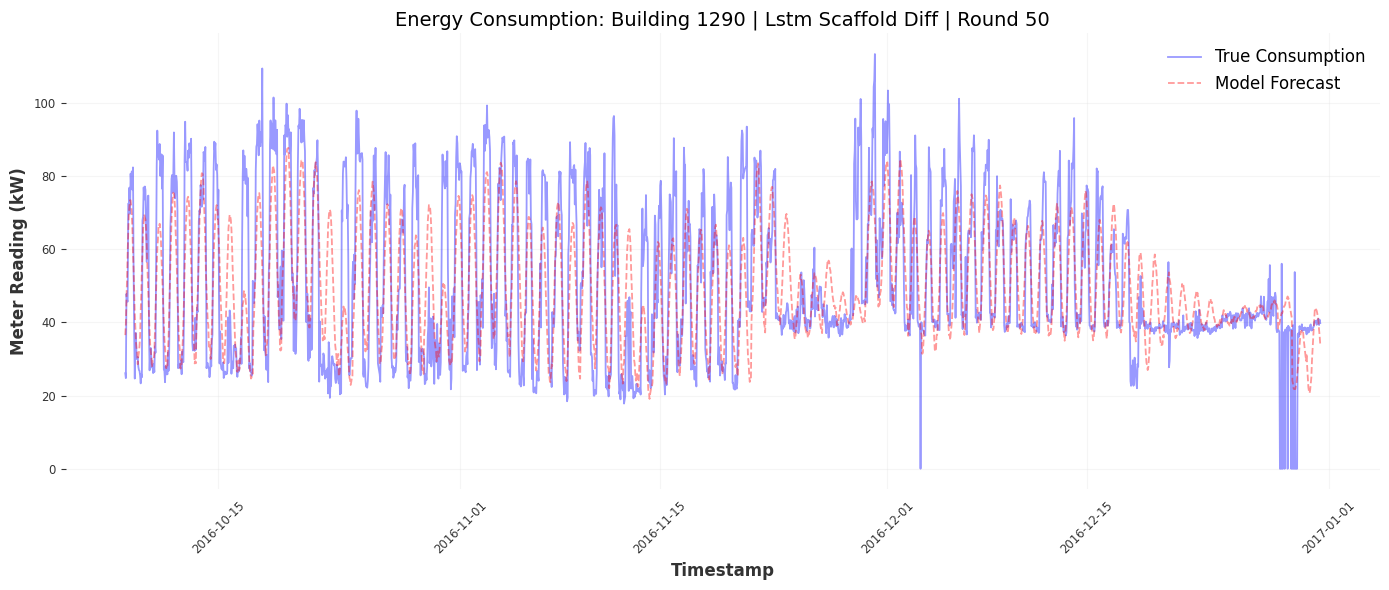

In [5]:
plot_truth_forecast_by_id(
    building_id=1290,
    model_strategy="lstm_scaffold_diff",
    input_dir="predictions40-50-168",
    output_dir="plots/lstm",
    round_num=50
)


✅ Plot saved to plots/gru/1290_gru_scaffold_diff_round50.png


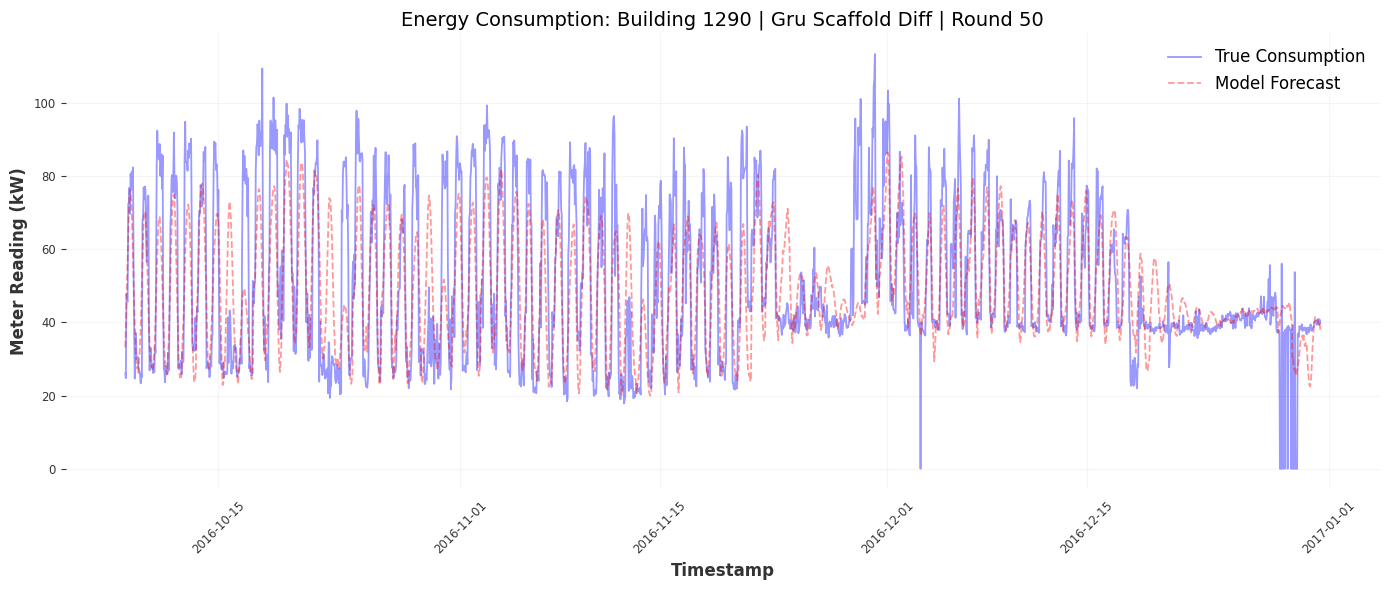

In [6]:
plot_truth_forecast_by_id(
    building_id=1290,
    model_strategy="gru_scaffold_diff",
    input_dir="predictions40-50-168",
    output_dir="plots/gru",
    round_num=50
)


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_truth_forecast_by_idaa(building_id, model_strategy, input_dir, output_dir, round_num=None,
                               show_plot=True):
    """
    Plot true vs predicted readings for a specific building and model strategy.

    Args:
        building_id (int or str): Building ID (e.g., 0)
        model_strategy (str): Model + strategy name (e.g., 'lstm_scaffold')
        input_dir (str): Folder containing the predictions CSVs
        output_dir (str): Folder to save the plot PNGs
        round_num (int, optional): Specific round to filter
        show_plot (bool): Whether to display the plot
    """
    # Construct file path
    input_file1 = Path(input_dir) / f"{building_id}_lstm_{model_strategy}.csv"
    input_file2 = Path(input_dir) / f"{building_id}_gru_{model_strategy}.csv"
    output_file = Path(output_dir) / f"{building_id}_{model_strategy}_round{round_num}.png"

    try:
        df1 = pd.read_csv(input_file1, parse_dates=['timestamp'])
        df2 = pd.read_csv(input_file2, parse_dates=['timestamp'])
    except Exception as e:
        print(f"❌ Error loading {input_file1}: {e}")
        return

    if round_num is not None:
        df1 = df1[df1['round'] == round_num]
        df2 = df2[df2['round'] == round_num]

    # Clean model_strategy text for title
    cleaned_strategy = model_strategy.replace("_", " ").title()

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df1['timestamp'], df1['true'], label='True Consumption', color='blue', alpha=0.7)
    plt.plot(df1['timestamp'], df1['pred'], label='Model Forecast LSTM', color='red', linestyle='--', alpha=0.5)
    plt.plot(df1['timestamp'], df2['pred'], label='Model Forecast GRU', color='black', linestyle='--', alpha=0.5)

    title = f"Energy Consumption Actual and Forecast: Building {building_id} |Strategy: {cleaned_strategy} | Round {round_num}"
    plt.title(title, fontsize=14)
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('Meter Reading (kW)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Save and show
    Path(output_file).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved to {output_file}")
    
    if show_plot:
        plt.show()
    plt.close()


✅ Plot saved to plots/gru/1290_scaffold_diff_round50.png


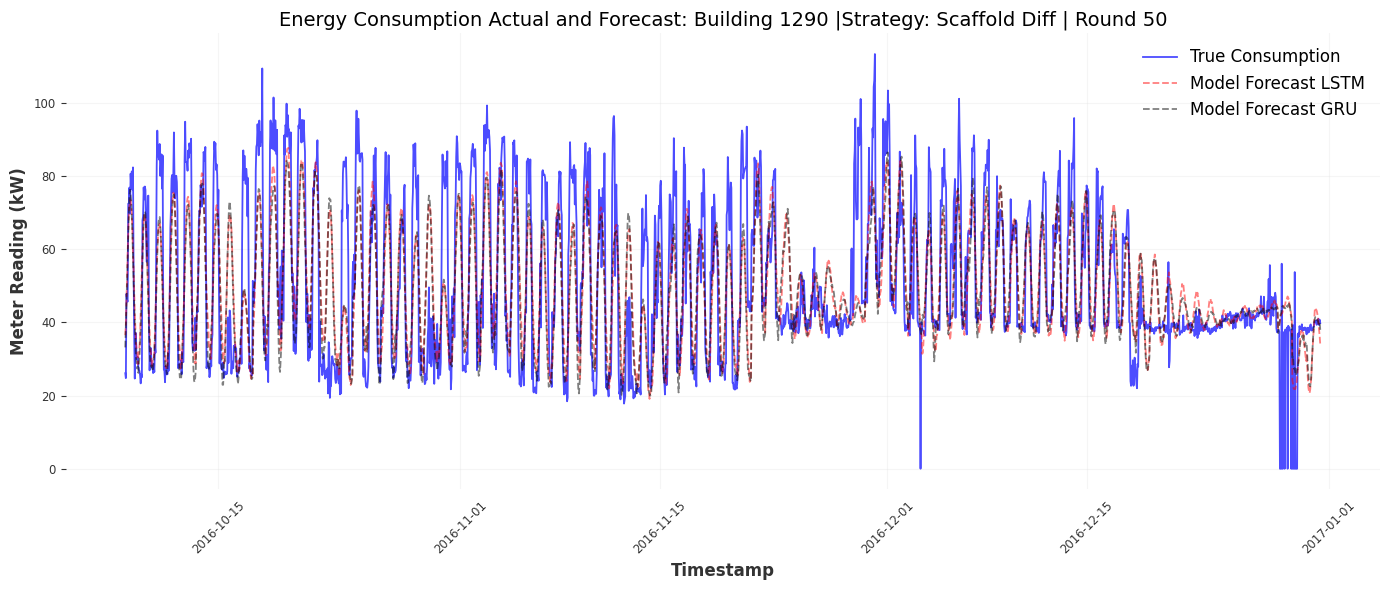

In [8]:
plot_truth_forecast_by_idaa(
    building_id=1290,
    model_strategy="scaffold_diff",
    input_dir="predictions40-50-168",
    output_dir="plots/gru",
    round_num=50
)


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_truth_by_id(building_id, model_strategy, input_dir, output_dir, round_num=None,
                               show_plot=True):
    """
    Plot true vs predicted readings for a specific building and model strategy.

    Args:
        building_id (int or str): Building ID (e.g., 0)
        model_strategy (str): Model + strategy name (e.g., 'lstm_scaffold')
        input_dir (str): Folder containing the predictions CSVs
        output_dir (str): Folder to save the plot PNGs
        round_num (int, optional): Specific round to filter
        show_plot (bool): Whether to display the plot
    """
    # Construct file path
    input_file = Path(input_dir) / f"{building_id}_{model_strategy}.csv"
    output_file = Path(output_dir) / f"{building_id}_{model_strategy}_round{round_num}.png"

    try:
        df = pd.read_csv(input_file, parse_dates=['timestamp'])
    except Exception as e:
        print(f"❌ Error loading {input_file}: {e}")
        return

    if round_num is not None:
        df = df[df['round'] == round_num]

    # Clean model_strategy text for title
    cleaned_strategy = model_strategy.replace("_", " ").title()

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df['timestamp'], df['true'], label='True Consumption', color='blue', alpha=0.9)
    # plt.plot(df['timestamp'], df['pred'], label='Model Forecast', color='red', linestyle='--', alpha=0.4)

    title = f"Energy Consumption: Building {building_id} | {cleaned_strategy} | Round {round_num}"
    plt.title(title, fontsize=14)
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('Meter Reading (kW)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Save and show
    Path(output_file).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved to {output_file}")
    
    if show_plot:
        plt.show()
    plt.close()


✅ Plot saved to plots/real/100_lstm_scaffold_diff_round50.png


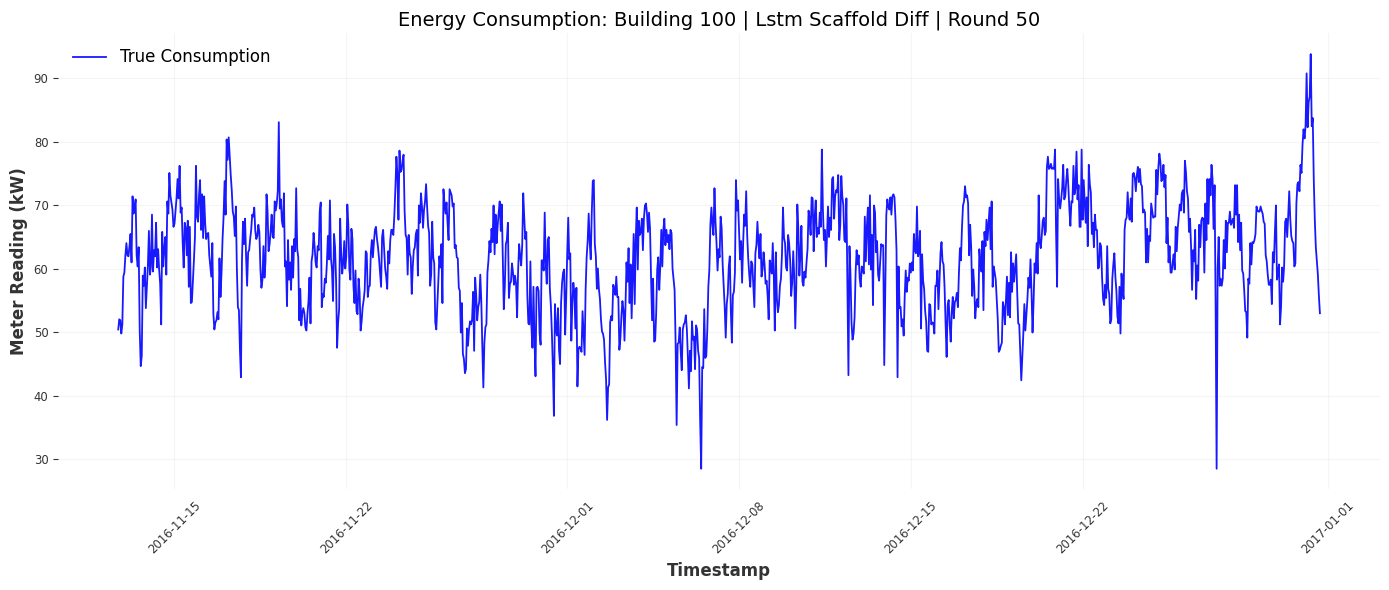

In [10]:
plot_truth_by_id(
    building_id=100,
    model_strategy="lstm_scaffold_diff",
    input_dir="predictions40-50-168",
    output_dir="plots/real",
    round_num=50
)

In [11]:
df = pd.read_feather("train_final.feather")
df.head()

,building_id,meter,timestamp,meter_reading,primary_use,air_temperature
7593144,0,0,2016-05-21 01:00:00,72.221012,Education,25.6
7593145,1,0,2016-05-21 01:00:00,39.611586,Education,25.6
7593146,2,0,2016-05-21 01:00:00,1.920567,Education,25.6
7593147,3,0,2016-05-21 01:00:00,111.532464,Education,25.6
7593148,4,0,2016-05-21 01:00:00,456.734799,Education,25.6


In [12]:
df_building = df[df["building_id"] == 256].copy()
df_building.head()

,building_id,meter,timestamp,meter_reading,primary_use,air_temperature
391,256,0,2016-01-01 00:00:00,7.15,Education,15.6
2690,256,0,2016-01-01 01:00:00,7.09,Education,13.9
4985,256,0,2016-01-01 02:00:00,6.98,Education,13.3
7283,256,0,2016-01-01 03:00:00,6.69,Education,12.2
9578,256,0,2016-01-01 04:00:00,6.90,Education,11.7


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_energy_consumption(df, building_id, output_dir=None, show_plot=True):
    """
    Plot energy consumption for a specific building from the given DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing 'building_id', 'timestamp', 'meter_reading'.
        building_id (int): Building ID to plot.
        output_dir (str or Path, optional): Folder to save the plot PNG. If None, no file is saved.
        show_plot (bool): Whether to display the plot.
    """
    df_building = df[df["building_id"] == building_id].copy()

    if df_building.empty:
        print(f"⚠️ No data found for building ID {building_id}")
        return

    plt.figure(figsize=(14, 6))
    plt.plot(df_building['timestamp'], df_building['meter_reading'],
             label='True Consumption', color='blue', alpha=0.9)

    title = f"Energy Consumption: Building {building_id}"
    plt.title(title, fontsize=14)
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('Meter Reading (kW)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()

    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        out_file = output_dir / f"building_{building_id}_consumption.png"
        plt.savefig(out_file, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {out_file}")

    if show_plot:
        plt.show()
    else:
        plt.close()


✅ Plot saved to plots/consumption/building_128_consumption.png


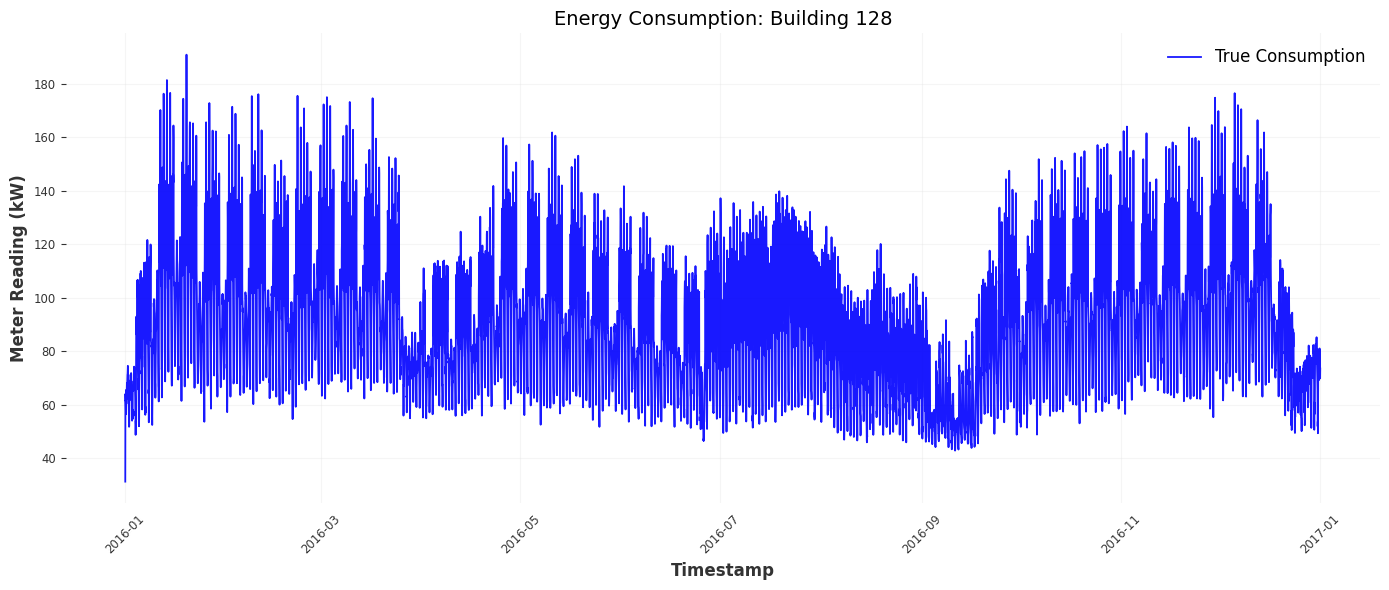

In [14]:
plot_energy_consumption(df, building_id=128, output_dir="plots/consumption", show_plot=True)


In [15]:
## working 

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_convergence_from_metrics(building_id, model_strategies, metric_name,
                                   metrics_dir, save_path=None, show_plot=True):
    """
    Plot convergence (e.g., SMAPE vs round) from per-round metrics CSVs.

    Args:
        building_id (int): Building ID to evaluate.
        model_strategies (list): List of model_strategy strings (e.g., ["gru__fedAvg", "lstm__diff_rev"]).
        metric_name (str): Column name to plot (e.g., "SMAPE (%)", "RMSE").
        metrics_dir (str or Path): Folder containing metrics CSVs.
        save_path (str or Path, optional): If provided, treated as folder to save plot PNGs.
        show_plot (bool): Whether to display the plot interactively.
    """
    metrics_dir = Path(metrics_dir)
    save_path = Path(save_path) if save_path else None

    if save_path:
        save_path.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(10, 6))

    for model_strategy in model_strategies:
        file_name = f"cid{building_id}_{model_strategy}_metrics.csv"
        file_path = metrics_dir / file_name

        if not file_path.exists():
            print(f"❌ Missing metrics file: {file_path}")
            continue

        df = pd.read_csv(file_path)
        if metric_name not in df.columns:
            print(f"⚠️ '{metric_name}' not found in {file_name}")
            continue

        plt.plot(df["round"], df[metric_name], marker='o', label=model_strategy)

    plt.title(f"Convergence on Building {building_id} ({metric_name})", fontsize=14)
    plt.xlabel("Round", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Save the figure
    if save_path:
        # Clean metric name to safe filename
        metric_clean = metric_name.replace(" ", "").replace("(", "").replace(")", "").replace("%", "pct")
        out_file = save_path / f"{building_id}_{metric_clean}.png"
        plt.savefig(out_file, dpi=300, bbox_inches="tight")
        print(f"✅ Saved plot to: {out_file}")

    if show_plot:
        plt.show()
    else:
        plt.close()


✅ Saved plot to: plots/lstm/190_SMAPEpct.png


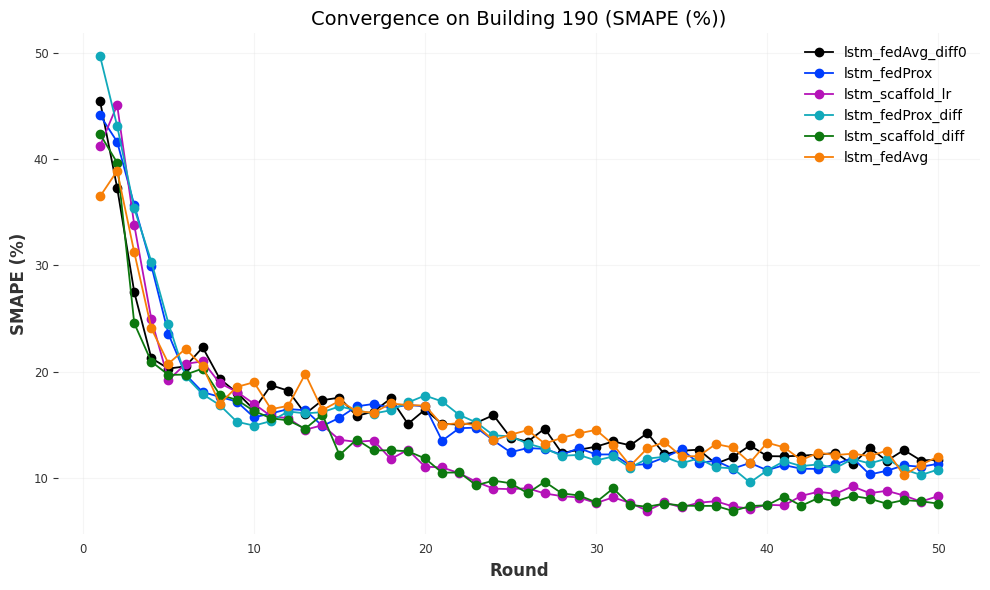

In [17]:
plot_convergence_from_metrics(
    building_id=190,
    model_strategies=["lstm_fedAvg_diff0", "lstm_fedProx", "lstm_scaffold_lr", "lstm_fedProx_diff","lstm_scaffold_diff","lstm_fedAvg" ],
    metric_name="SMAPE (%)",
    metrics_dir="metrics-plots",
    save_path="plots/lstm/"  # <== folder only!
)



✅ Saved plot to: plots/gru/128_SMAPEpct.png


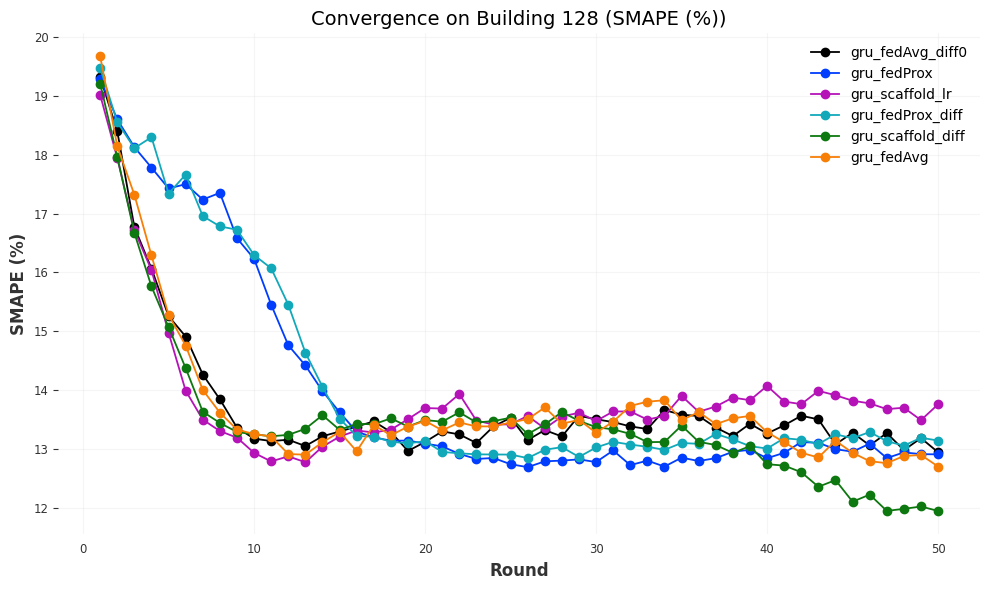

In [18]:
plot_convergence_from_metrics(
    building_id=128,
    model_strategies=["gru_fedAvg_diff0", "gru_fedProx", "gru_scaffold_lr", "gru_fedProx_diff","gru_scaffold_diff","gru_fedAvg" ],
    metric_name="SMAPE (%)",
    metrics_dir="metrics-plots",
    save_path="plots/gru/"  # <== folder only!
)


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# def clean_label(label):
#     # Remove underscores and digits, then capitalize words
#     label = re.sub(r"[_\d]+", " ", label)  # replace _ and digits with space
#     label = " ".join(word.capitalize() for word in label.split())
#     return label

def clean_label(label):
    # Remove "_lr" or "lr" if it's at the end
    label = re.sub(r"(?:_)?lr$", "", label)
    # Remove underscores and digits
    label = re.sub(r"[_\d]+", " ", label)
    # Capitalize words
    label = " ".join(word.capitalize() for word in label.split())
    return label

def plot_convergence_from_metrics2(building_id, model_strategies, metric_name,
                                   metrics_dir, save_path=None, show_plot=True):
    """
    Plot convergence (e.g., SMAPE vs round) from per-round metrics CSVs.

    Args:
        building_id (int): Building ID to evaluate.
        model_strategies (list): List of model_strategy strings (e.g., ["gru__fedAvg", "lstm__diff_rev"]).
        metric_name (str): Column name to plot (e.g., "SMAPE (%)", "RMSE").
        metrics_dir (str or Path): Folder containing metrics CSVs.
        save_path (str or Path, optional): If provided, treated as folder to save plot PNGs.
        show_plot (bool): Whether to display the plot interactively.
    """
    metrics_dir = Path(metrics_dir)
    save_path = Path(save_path) if save_path else None

    if save_path:
        save_path.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(10, 6))

    for model_strategy in model_strategies:
        file_name = f"cid{building_id}_{model_strategy}_metrics.csv"
        file_path = metrics_dir / file_name

        if not file_path.exists():
            print(f"❌ Missing metrics file: {file_path}")
            continue

        df = pd.read_csv(file_path)
        if metric_name not in df.columns:
            print(f"⚠️ '{metric_name}' not found in {file_name}")
            continue

        # Clean and format label
        label = clean_label(model_strategy)
        plt.plot(df["round"], df[metric_name], marker='o', label=label)

    plt.title(f"Convergence on Building {building_id} ({metric_name})", fontsize=14)
    plt.xlabel("Round", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    if save_path:
        metric_clean = metric_name.replace(" ", "").replace("(", "").replace(")", "").replace("%", "pct")
        out_file = save_path / f"{building_id}_{metric_clean}.png"
        plt.savefig(out_file, dpi=300, bbox_inches="tight")
        print(f"✅ Saved plot to: {out_file}")

    if show_plot:
        plt.show()
    else:
        plt.close()


In [23]:
from scipy.interpolate import make_interp_spline
def plot_convergence_from_metrics2(building_id, model_strategies, metric_name,
                                   metrics_dir, save_path=None, show_plot=True,
                                   smooth=True):
    metrics_dir = Path(metrics_dir)
    save_path = Path(save_path) if save_path else None

    if save_path:
        save_path.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(6, 5))

    for model_strategy in model_strategies:
        file_name = f"cid{building_id}_{model_strategy}_metrics.csv"
        file_path = metrics_dir / file_name

        if not file_path.exists():
            print(f"❌ Missing metrics file: {file_path}")
            continue

        df = pd.read_csv(file_path)
        if metric_name not in df.columns:
            print(f"⚠️ '{metric_name}' not found in {file_name}")
            continue

        x = df["round"].values
        y = df[metric_name].values
        label = clean_label(model_strategy)

        if smooth and len(x) > 3:
            # Fit spline for smoother curve
            x_new = np.linspace(x.min(), x.max(), 300)
            spline = make_interp_spline(x, y, k=3)
            y_smooth = spline(x_new)
            plt.plot(x_new, y_smooth, label=label)
        else:
            plt.plot(x, y, marker='o', markersize=4, label=label)

    plt.title(f"Convergence on Building {building_id} ({metric_name})", fontsize=14)
    plt.xlabel("Round", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    if save_path:
        metric_clean = metric_name.replace(" ", "").replace("(", "").replace(")", "").replace("%", "pct")
        out_file = save_path / f"{building_id}_{metric_clean}.png"
        plt.savefig(out_file, dpi=300, bbox_inches="tight")
        print(f"✅ Saved plot to: {out_file}")

    if show_plot:
        plt.show()
    else:
        plt.close()

✅ Saved plot to: plots/gru/128_MAE.png


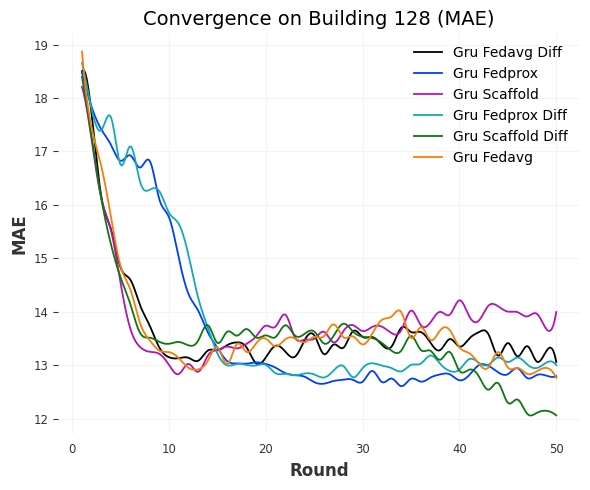

In [24]:
plot_convergence_from_metrics2(
    building_id=128,
    model_strategies=["gru_fedAvg_diff0", "gru_fedProx", "gru_scaffold_lr", "gru_fedProx_diff","gru_scaffold_diff","gru_fedAvg" ],
    metric_name="MAE",
    metrics_dir="metrics-plots",
    save_path="plots/gru/",  # <== folder only!
    smooth=True
)


✅ Saved plot to: plots/lstm/128_SMAPEpct.png


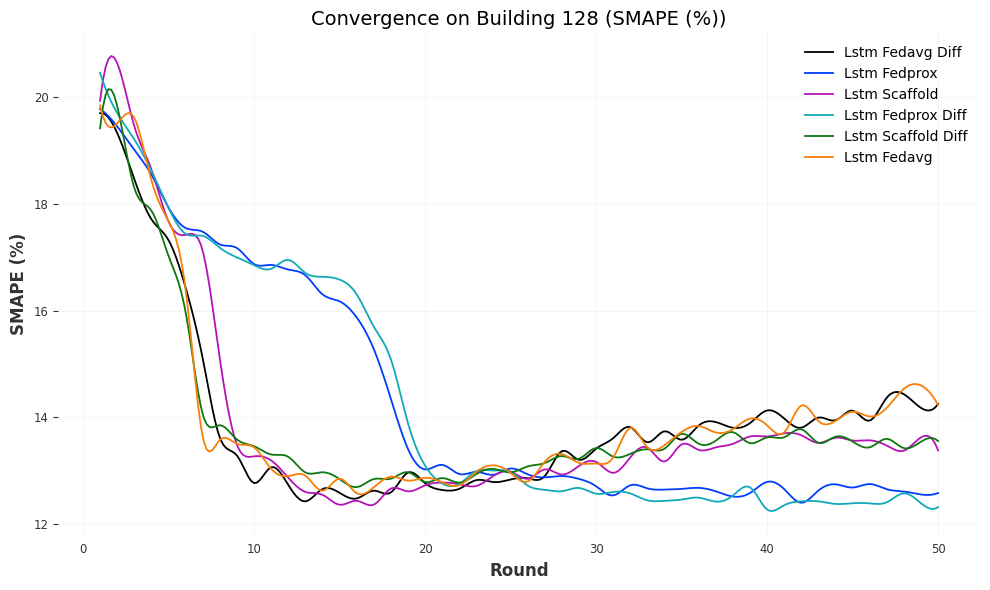

In [22]:
plot_convergence_from_metrics2(
    building_id=128,
    model_strategies=["lstm_fedAvg_diff0", "lstm_fedProx", "lstm_scaffold_lr", "lstm_fedProx_diff","lstm_scaffold_diff","lstm_fedAvg" ],
    metric_name="SMAPE (%)",
    metrics_dir="metrics-plots",
    save_path="plots/lstm/"  # <== folder only!
)

